# Import Libraries

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras import layers
from keras.models import Model
from keras.utils import plot_model
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from keras.optimizers import Adam
from tensorflow import argmax
from sklearn.preprocessing import OneHotEncoder
from keras.models import load_model
from keras.callbacks import LearningRateScheduler
import seaborn as sns


## Load Data

In [2]:
data_path = 'D:/University/Deep_Learning/HWs/HW02/NN_HW2_Face_Emotion/'

In [3]:
labels = os.listdir(data_path + 'TRAIN')

In [4]:
labels

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [5]:
def load_data(data_dir, labels):
    images = []
    target_labels = []

    for label in labels:
        label_dir = os.path.join(data_dir, label)
        image_files = os.listdir(label_dir)
        
        for image_file in image_files:
            image_path = os.path.join(label_dir, image_file)

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            images.append(image)
            target_labels.append(label)

    images = np.array(images)
    target_labels = np.array(target_labels)

    return images, target_labels

In [6]:
X_train, y_train = load_data(data_path + 'TRAIN', labels)
X_tune, y_tune = load_data(data_path + 'TUNE', labels)

In [7]:
X_train.shape

(8000, 128, 128, 3)

In [8]:
X_tune.shape

(1600, 128, 128, 3)

In [9]:
def plot_samples(labels, X, y):
    cnt = 1

    for label in labels:
        ind = np.where(y == label)[0][0]
        sample = X[ind]
        plt.subplot(2, 4, cnt)
        plt.imshow(sample)
        plt.xticks([])
        plt.yticks([])
        plt.title(label)
        cnt += 1

    plt.tight_layout()
    plt.show()

Let's see a sample image of ecah class.

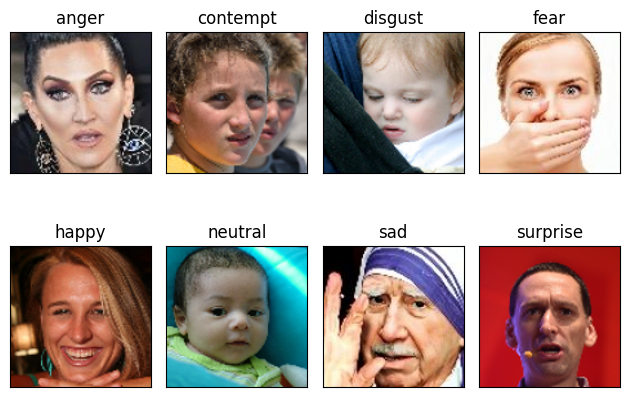

In [10]:
plot_samples(labels, X_train, y_train)

## Preprocessing and Data Augmentation

In [11]:
# normalization:
X_train_normalized = X_train / 255.0
X_tune_normalized = X_tune / 255.0

In [12]:
classes = np.array(labels)
classes = classes.reshape(-1, 1)

enc = OneHotEncoder(sparse_output=False)
enc.fit(classes)

y_train_encoded = y_train.reshape(-1, 1)
y_train_encoded = enc.transform(y_train_encoded)
y_tune_encoded = y_tune.reshape(-1, 1)
y_tune_encoded = enc.transform(y_tune_encoded)

In [13]:
y_train_encoded.shape

(8000, 8)

In [14]:
img_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [15]:
sample_image = np.expand_dims(X_train_normalized[0], axis=0)

In [16]:
aug_iter = img_gen.flow(sample_image)
aug_images = [next(aug_iter)[0] for i in range(10)]

In [17]:
def plot_images(images_arr):
    _, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

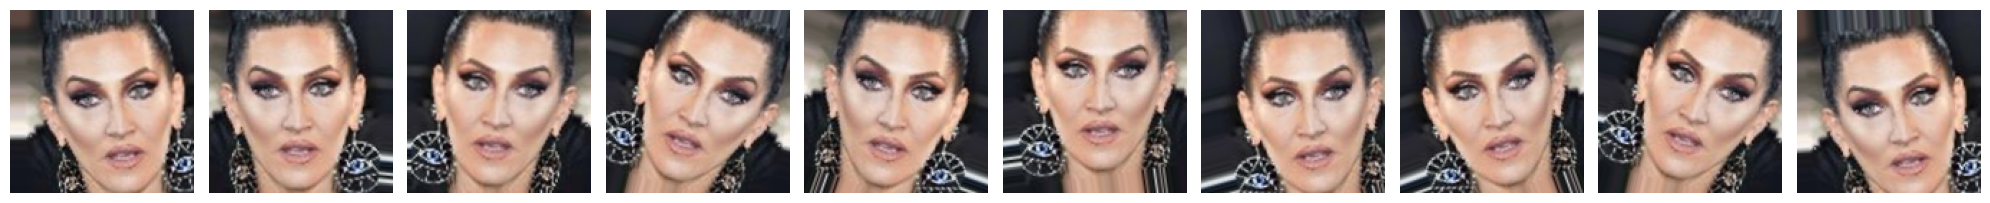

In [18]:
plot_images(aug_images)

Here, you can observe the impact of data augmentation on the first image of the training dataset. Nonetheless, the conventional augmentation approach of creating pictures and saving them consumes an immense amount of memory, leading to RAM crashes. Consequently, we opt for the 'ImageDataGenerator' flow method to generate images while training.

In [19]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_normalized,
                                                                          y_train_encoded,
                                                                          test_size=0.25,
                                                                          random_state=42)

In [20]:
batch_size = 60
train_data_gen = img_gen.flow(X_train_split, y_train_split, batch_size=batch_size)

## AlexNet Varaint Model

### Architecture

In [21]:
def AlexNetVariant():
    model_input = layers.Input((128, 128, 3))

    x = layers.Conv2D(filters=16, kernel_size=(9, 9), padding='same',
                        activation='relu')(model_input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.GaussianDropout(0.2)(x)

    x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.GaussianDropout(0.2)(x)

    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.GaussianDropout(0.2)(x)

    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.GaussianDropout(0.2)(x)

    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.GaussianDropout(0.2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(8, activation='softmax')(x)

    model = Model(inputs=model_input, outputs=x)

    return model



In [22]:
alex_net_v = AlexNetVariant()
alex_net_v.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      3904      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 gaussian_dropout (Gaussian  (None, 64, 64, 16)        0         
 Dropout)                                                        
                                                           

In [23]:
def display_model(model, model_name):
    return plot_model(
        model,
        to_file=model_name + '.png',
        show_shapes=True,
        show_dtype=False,
        show_layer_names=False,
        show_layer_activations=True,
        dpi=100
    )

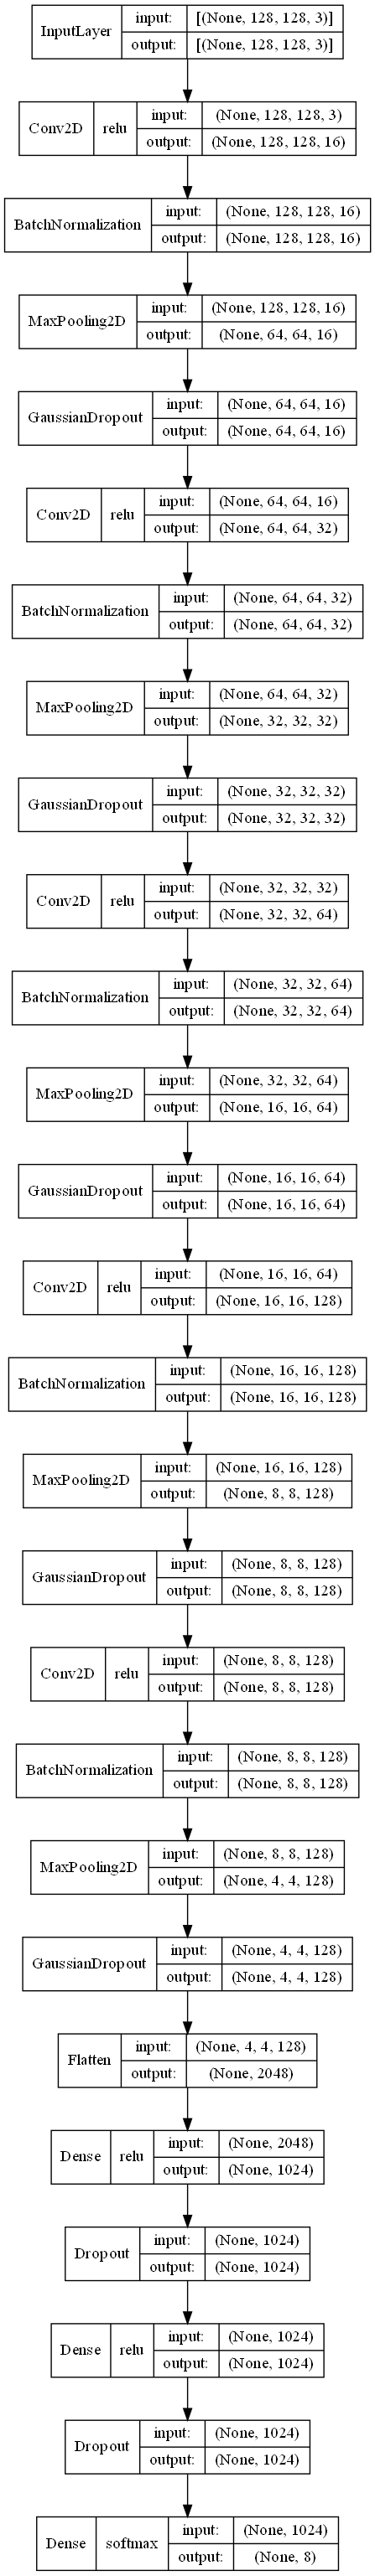

In [24]:
display_model(alex_net_v, 'alex_net_v')

Now, you can observe the detailed architecture of the AlexNet variant model.

### Train and Tune

In [25]:
class_labels = np.argmax(y_train_split, axis=1)

In [26]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(class_labels),
                                    y=class_labels)

class_weights = dict(enumerate(class_weights))

In [27]:
class_weights

{0: 1.0053619302949062,
 1: 1.0387811634349031,
 2: 0.9933774834437086,
 3: 0.967741935483871,
 4: 0.9946949602122016,
 5: 1.0,
 6: 1.0135135135135136,
 7: 0.9894459102902374}

In [28]:
def lr_scheduler(epochs, lr):
    if epochs < 5:
        return lr
    else:
        return 0.93 * lr

In [29]:
alex_net_v.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9,
                             beta_2=0.999, epsilon=10 ** (-8)),
                             loss='categorical_crossentropy',
                             metrics=[tf.keras.metrics.CategoricalAccuracy()])

First, we train the AlexNet variant model from scratch. We then fine-tune the trained model and finally compare the losses and accuracies of the trained and fine-tuned models. Let's go ahead and train the model from scratch!

In [30]:
train_data_count = X_train_split.shape[0]
steps_per_epoch = train_data_count // batch_size

callback = LearningRateScheduler(lr_scheduler)

history=alex_net_v.fit(train_data_gen, epochs=24, steps_per_epoch=steps_per_epoch,
                  batch_size=batch_size, validation_data=(X_val_split, y_val_split),
                  class_weight=class_weights,
                  callbacks=[callback])

Epoch 1/24

100/100 [==============================] - 44s 417ms/step - loss: 2.5742 - categorical_accuracy: 0.1363 - val_loss: 2.3377 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 2/24
100/100 [==============================] - 44s 436ms/step - loss: 2.1049 - categorical_accuracy: 0.1542 - val_loss: 2.1245 - val_categorical_accuracy: 0.1635 - lr: 0.0010
Epoch 3/24
100/100 [==============================] - 43s 432ms/step - loss: 2.0635 - categorical_accuracy: 0.1545 - val_loss: 2.0490 - val_categorical_accuracy: 0.1680 - lr: 0.0010
Epoch 4/24
100/100 [==============================] - 45s 450ms/step - loss: 2.0379 - categorical_accuracy: 0.1723 - val_loss: 2.0316 - val_categorical_accuracy: 0.1970 - lr: 0.0010
Epoch 5/24
100/100 [==============================] - 44s 439ms/step - loss: 2.0333 - categorical_accuracy: 0.1710 - val_loss: 4.8191 - val_categorical_accuracy: 0.1325 - lr: 0.0010
Epoch 6/24
100/100 [==============================] - 44s 437ms/step - loss: 2.0163 - cat

Let's save the trained model and its history for future use

In [6]:
models_path = 'D:/University/Deep_Learning/HWs/HW02/models/'

In [32]:
def save_model(model, model_name, history_name, model_history):
    model.save(models_path + model_name)
    np.save(models_path + history_name, model_history)

In [33]:
save_model(alex_net_v, 'trained_alex_v.keras', 'trained_alex_v.npy', history)

In [7]:
def load_saved_model(model_name, history_name):
    model = load_model(models_path + model_name)
    history = np.load(models_path + history_name, allow_pickle=True).item()

    return model, history

In [9]:
def plot_metrics(model_history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['categorical_accuracy'], label='Training Accuracy')
    plt.plot(model_history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['loss'], label='Training Loss')
    plt.plot(model_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.show()

In [36]:
alex_net_v_saved, alex_net_v_history = load_saved_model('trained_alex_v.keras',
                                                        'trained_alex_v.npy')

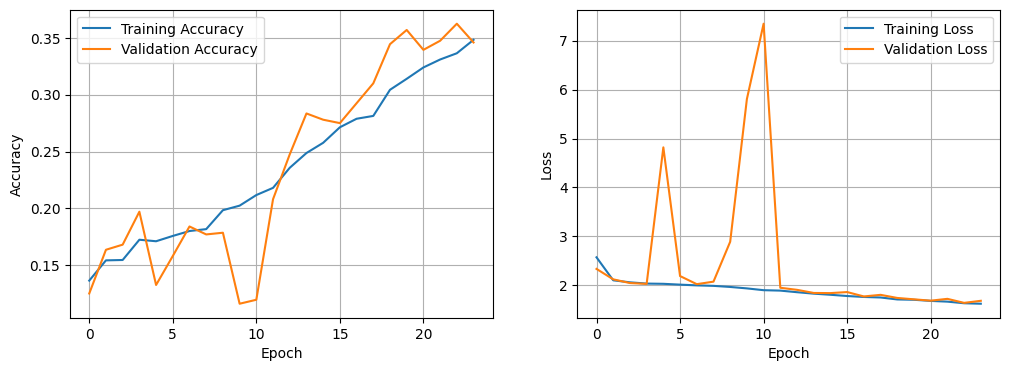

In [37]:
plot_metrics(alex_net_v_history)

In the above plots, you can observe the loss and accuracy of the training and validation datasets for a trained variant of the AlexNet model without any fine-tuning.

In [38]:
def fine_tune(model, frozens_count):

    for layer in model.layers[:frozens_count]:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001),
                             loss='categorical_crossentropy',
                             metrics=[tf.keras.metrics.CategoricalAccuracy()])

    callback = LearningRateScheduler(lr_scheduler)

    history=model.fit(X_tune_normalized, y_tune_encoded, epochs=16,
                      validation_data=(X_val_split, y_val_split),
                      class_weight=class_weights,
                      callbacks=[callback])

    return model, history


In [39]:
fine_tuned_alex_v, fine_tuned_alex_v_history = fine_tune(alex_net_v_saved, 9)

Epoch 1/16
50/50 [==============================] - 13s 221ms/step - loss: 1.9090 - categorical_accuracy: 0.2556 - val_loss: 1.7152 - val_categorical_accuracy: 0.3130 - lr: 0.0010
Epoch 2/16
50/50 [==============================] - 10s 207ms/step - loss: 1.8248 - categorical_accuracy: 0.2625 - val_loss: 1.7178 - val_categorical_accuracy: 0.3290 - lr: 0.0010
Epoch 3/16
50/50 [==============================] - 11s 215ms/step - loss: 1.7776 - categorical_accuracy: 0.3031 - val_loss: 1.9080 - val_categorical_accuracy: 0.3040 - lr: 0.0010
Epoch 4/16
50/50 [==============================] - 11s 212ms/step - loss: 1.7478 - categorical_accuracy: 0.2937 - val_loss: 1.8775 - val_categorical_accuracy: 0.3220 - lr: 0.0010
Epoch 5/16
50/50 [==============================] - 11s 214ms/step - loss: 1.7541 - categorical_accuracy: 0.3106 - val_loss: 2.0129 - val_categorical_accuracy: 0.2695 - lr: 0.0010
Epoch 6/16
50/50 [==============================] - 11s 213ms/step - loss: 1.7252 - categorical_accu

In [40]:
save_model(fine_tuned_alex_v, 'tuned_alex_v.keras', 'tuned_alex_v.npy',
           fine_tuned_alex_v_history)

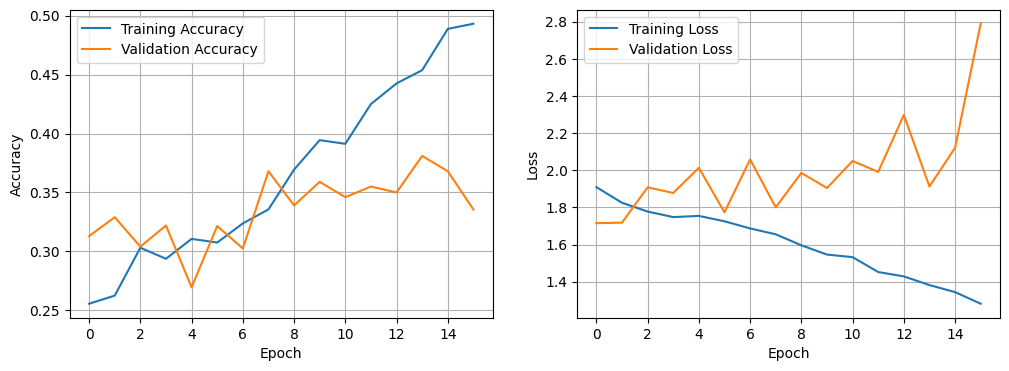

In [41]:
plot_metrics(fine_tuned_alex_v_history)

In [42]:
def draw_roc_auc(y_pred):
    n_classes = 8

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val_split[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')  # Plot the diagonal line (random guessing)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

In [43]:
def metrics_report(y_pred):
    y_pred = np.argmax(y_pred, axis=1)
    print(classification_report(y_pred=y_pred,
                                y_true=np.argmax(y_val_split, axis=1)))

In [44]:
def draw_cm(y_pred):
    n_classes = 8
    y_pred = np.argmax(y_pred, axis=1)
    
    cm = confusion_matrix(np.argmax(y_val_split, axis=1), y_pred)

    plt.figure(figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                xticklabels=range(n_classes),
                yticklabels=range(n_classes))
    
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.title('Confusion Matrix')
    
    plt.show()

In [45]:
y_pred = fine_tuned_alex_v.predict(X_val_split)

63/63 [==============================] - 5s 70ms/step


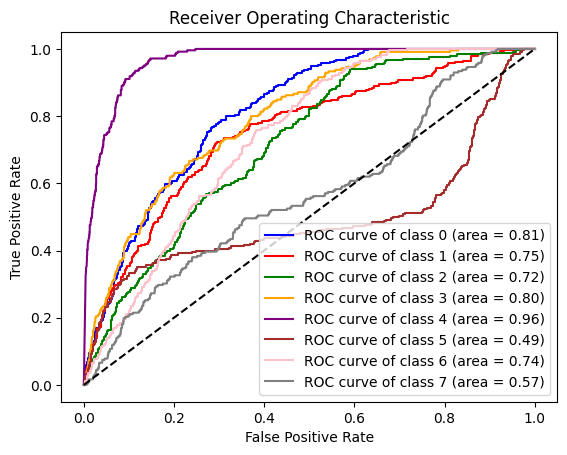

              precision    recall  f1-score   support

           0       0.36      0.24      0.29       254
           1       0.33      0.50      0.40       278
           2       0.26      0.20      0.22       245
           3       0.38      0.33      0.35       225
           4       0.39      0.99      0.56       246
           5       0.28      0.20      0.24       250
           6       0.28      0.17      0.21       260
           7       0.17      0.05      0.07       242

    accuracy                           0.34      2000
   macro avg       0.31      0.33      0.29      2000
weighted avg       0.31      0.34      0.29      2000



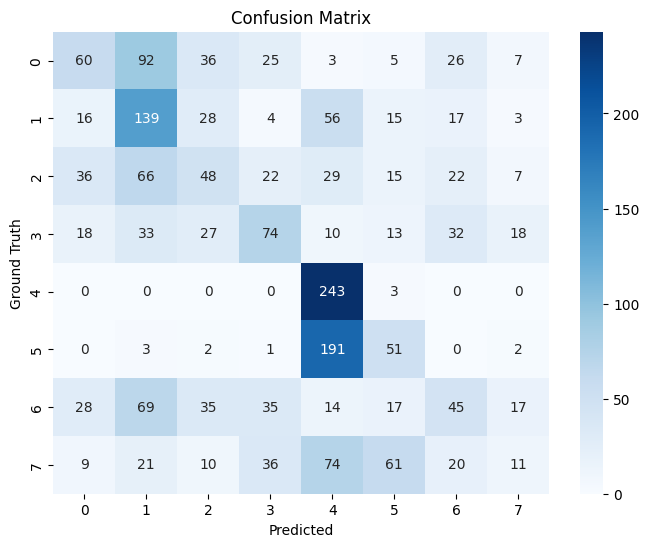

In [46]:
draw_roc_auc(y_pred)
metrics_report(y_pred)
draw_cm(y_pred)

## VGGNet Variant

### Architecture

In [47]:
def VGGNetVariant():
    model_input = layers.Input((128, 128, 3))

    x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same',
                        activation='relu')(model_input)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.GaussianDropout(0.2)(x)

    x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.GaussianDropout(0.2)(x)

    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.GaussianDropout(0.2)(x)

    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.GaussianDropout(0.2)(x)

    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.GaussianDropout(0.2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(8, activation='softmax')(x)

    model = Model(inputs=model_input, outputs=x)

    return model



In [48]:
vgg_net_v = VGGNetVariant()
vgg_net_v.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 batch_normalization_5 (Bat  (None, 128, 128, 16)      64        
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization_6 (Bat  (None, 128, 128, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 16)        0   

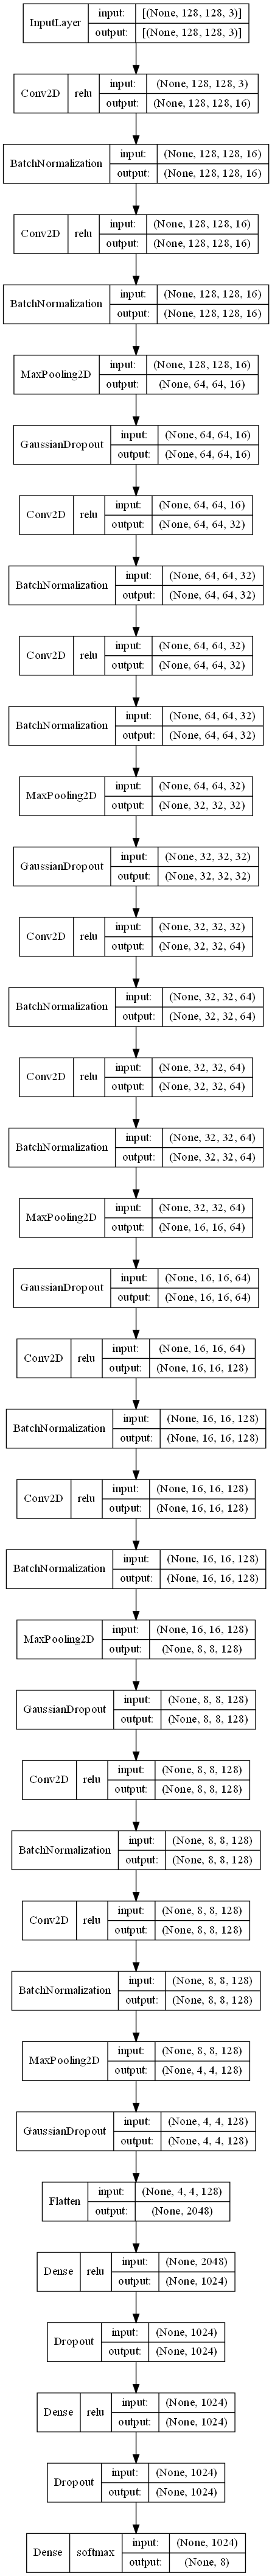

In [49]:
display_model(vgg_net_v, 'vgg_net_v')

In [50]:
vgg_net_v.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9,
                             beta_2=0.999, epsilon=10 ** (-8)),
                             loss='categorical_crossentropy',
                             metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [51]:
trained_vgg_history = vgg_net_v.fit(train_data_gen, epochs=24, steps_per_epoch=steps_per_epoch,
                  batch_size=batch_size, validation_data=(X_val_split, y_val_split),
                  class_weight=class_weights,
                  callbacks=[callback])

Epoch 1/24
100/100 [==============================] - 67s 634ms/step - loss: 2.5980 - categorical_accuracy: 0.1473 - val_loss: 2.0957 - val_categorical_accuracy: 0.1325 - lr: 0.0010
Epoch 2/24
100/100 [==============================] - 60s 598ms/step - loss: 2.1051 - categorical_accuracy: 0.1570 - val_loss: 2.0665 - val_categorical_accuracy: 0.1530 - lr: 0.0010
Epoch 3/24
100/100 [==============================] - 59s 585ms/step - loss: 2.0608 - categorical_accuracy: 0.1738 - val_loss: 2.0268 - val_categorical_accuracy: 0.1820 - lr: 0.0010
Epoch 4/24
100/100 [==============================] - 58s 581ms/step - loss: 2.0168 - categorical_accuracy: 0.1765 - val_loss: 1.9837 - val_categorical_accuracy: 0.1840 - lr: 0.0010
Epoch 5/24
100/100 [==============================] - 57s 572ms/step - loss: 2.0024 - categorical_accuracy: 0.1853 - val_loss: 1.9634 - val_categorical_accuracy: 0.1925 - lr: 0.0010
Epoch 6/24
100/100 [==============================] - 59s 586ms/step - loss: 1.9765 - cate

In [52]:
save_model(vgg_net_v, 'trained_vgg_v.keras', 'trained_vgg_v.npy',
           trained_vgg_history)

In [8]:
vgg_net_v_saved, vgg_net_v_history = load_saved_model('trained_vgg_v.keras',
                                                        'trained_vgg_v.npy')

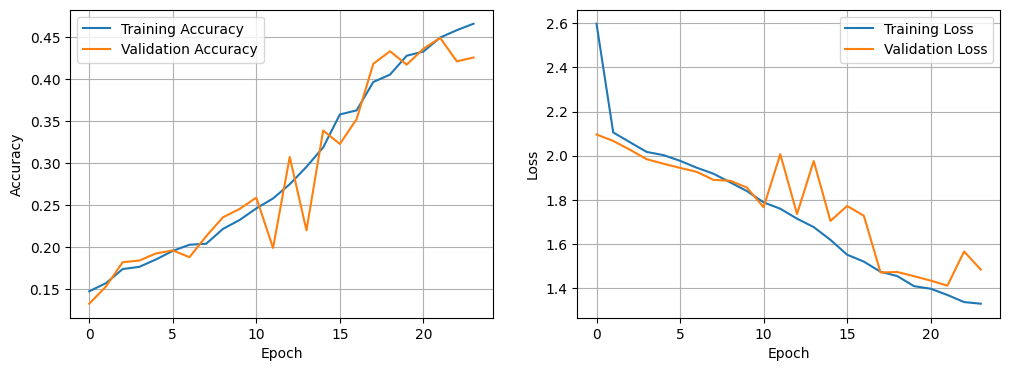

In [54]:
plot_metrics(vgg_net_v_history)

In [55]:
fine_tuned_vgg_v, fine_tuned_vgg_v_history = fine_tune(vgg_net_v_saved, 25)

Epoch 1/16
50/50 [==============================] - 14s 240ms/step - loss: 1.8212 - categorical_accuracy: 0.3081 - val_loss: 1.6231 - val_categorical_accuracy: 0.3920 - lr: 0.0010
Epoch 2/16
50/50 [==============================] - 11s 223ms/step - loss: 1.6994 - categorical_accuracy: 0.3431 - val_loss: 1.5247 - val_categorical_accuracy: 0.4185 - lr: 0.0010
Epoch 3/16
50/50 [==============================] - 11s 219ms/step - loss: 1.6733 - categorical_accuracy: 0.3500 - val_loss: 1.5818 - val_categorical_accuracy: 0.4295 - lr: 0.0010
Epoch 4/16
50/50 [==============================] - 11s 219ms/step - loss: 1.6285 - categorical_accuracy: 0.3781 - val_loss: 1.6874 - val_categorical_accuracy: 0.4055 - lr: 0.0010
Epoch 5/16
50/50 [==============================] - 11s 219ms/step - loss: 1.6090 - categorical_accuracy: 0.3787 - val_loss: 1.7630 - val_categorical_accuracy: 0.4005 - lr: 0.0010
Epoch 6/16
50/50 [==============================] - 11s 219ms/step - loss: 1.6003 - categorical_accu

In [56]:
save_model(fine_tuned_vgg_v, 'fine_tuned_vgg.keras',
           'fine_tuned_vgg_history.npy', fine_tuned_vgg_v_history)

In [10]:
tuned_vgg_saved, tuned_vgg_history = load_saved_model('fine_tuned_vgg.keras',
                                                        'fine_tuned_vgg_history.npy')

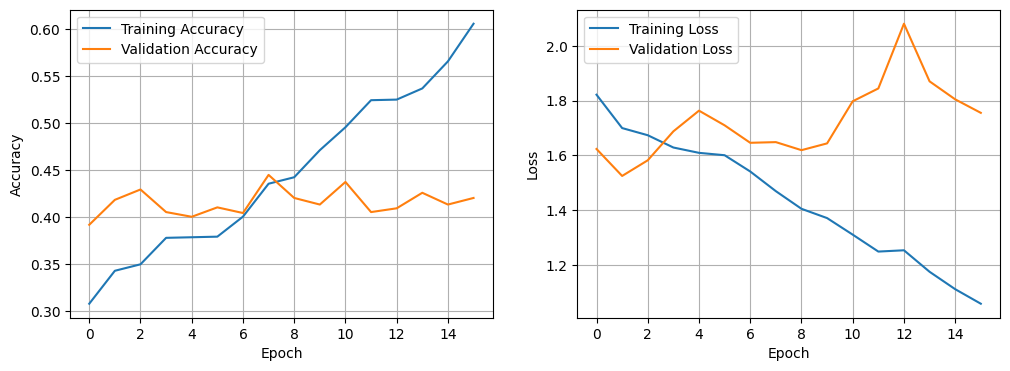

In [57]:
plot_metrics(fine_tuned_vgg_v_history)

In [ ]:
plot_metrics(tuned_vgg_history)

In [58]:
y_pred = fine_tuned_vgg_v.predict(X_val_split)

63/63 [==============================] - 4s 67ms/step


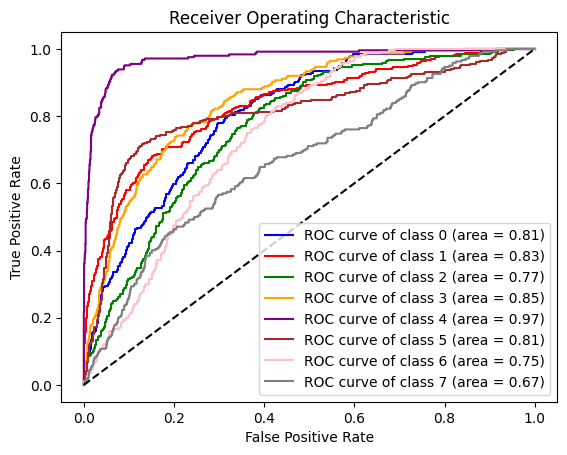

              precision    recall  f1-score   support

           0       0.42      0.32      0.36       254
           1       0.40      0.66      0.50       278
           2       0.34      0.18      0.24       245
           3       0.43      0.20      0.27       225
           4       0.62      0.93      0.75       246
           5       0.49      0.57      0.53       250
           6       0.27      0.30      0.28       260
           7       0.23      0.15      0.18       242

    accuracy                           0.42      2000
   macro avg       0.40      0.41      0.39      2000
weighted avg       0.40      0.42      0.39      2000



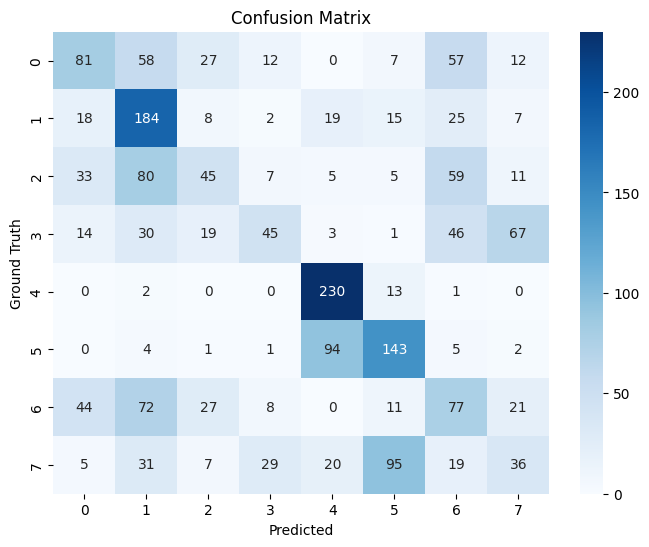

In [59]:
draw_roc_auc(y_pred)
metrics_report(y_pred)
draw_cm(y_pred)